In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 2
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
from scipy.signal import butter, filtfilt, freqz
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

# Load Data

In [11]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo'], verbose=False)
dt = get_sample_interval(f, units='s')
lfp = f['lfp']

In [14]:
# dt, window, overlap are in seconds
# pts has shape (num_time_steps, num_dims)
def compute_eigs(pts, dt, window=1, stride=None):
    n = pts.shape[0]
    k = int(window/dt) # window size in time steps
    # default to window stride
    if stride is None:
        r = 0 # overlap size in time steps
    else:
        r = int((window - stride)/dt) # overlap size in time steps
    
    num_win = int(np.floor((n - k)/(k - r) + 1))
    eigs = np.zeros((num_win, pts.shape[1]))
    for i in tqdm(range(num_win)):
        chunk = pts[i*(k - r):i*(k - r) + k]
        model = VAR(chunk)
        results = model.fit(1)
        e,_ = np.linalg.eig(results.coefs[0])      
        eigs[i] = np.abs(np.real(e))
    
    return eigs

In [24]:
window = 0.5 # s
stride = 0.01 # s

eigs = {}
# for area in session_info['areas']:
for area in ['vlPFC']:
    print(area)
    electrode_inds = np.where(electrode_info['area'] == area)[0]
    eigs[area] = compute_eigs(lfp[electrode_inds, :].T, dt, window, stride)

vlPFC


In [37]:
# save(eigs, f"../../__data__/eigs_vlPFC_window_{window}_stride_{stride}")

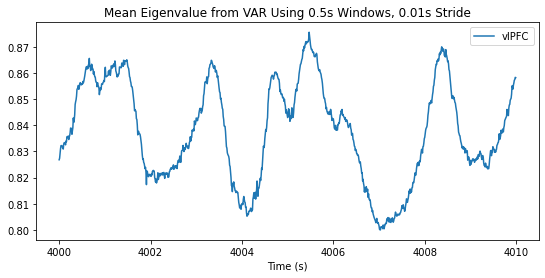

In [35]:
plt.figure(figsize=(9, 4))
start = 4000 # s
end = 4010 # s

start = int(start/stride)
end = int(end/stride)

for area in eigs.keys():
    plt.plot((np.arange(eigs[area].shape[0])*stride)[start:end], eigs[area].mean(1)[start:end], label=area)
plt.title(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

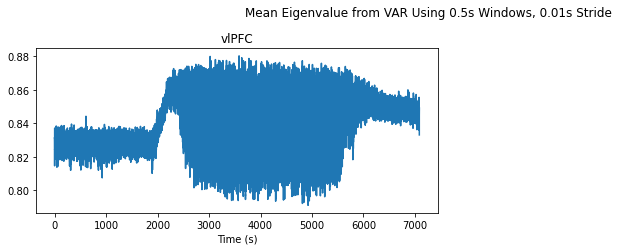

In [28]:
start = 20
end = -30
plt.figure(figsize=(12, 6))
for i, area in enumerate(eigs.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot((np.arange(eigs[area].shape[0])*stride)[start:end], eigs[area].mean(1)[start:end], label=area, c=f"C{i}")
    plt.xlabel("Time (s)")
    plt.title(area)
plt.suptitle(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
# plt.legend()
plt.tight_layout()
plt.show()

# Load and Compare to Up States and Down States

In [5]:
window = 0.5 # s
stride = 0.01 # s 
eigs = load(f"../../__data__/eigs_vlPFC_window_{window}_stride_{stride}")

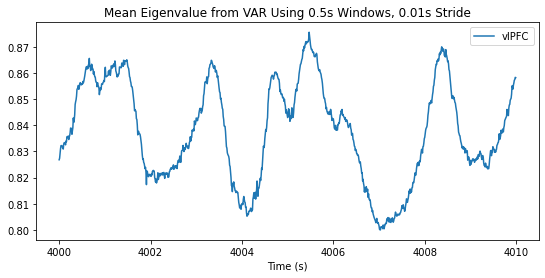

In [6]:
plt.figure(figsize=(9, 4))
start = 4000 # s
end = 4010 # s

start = int(start/stride)
end = int(end/stride)

for area in eigs.keys():
    plt.plot((np.arange(eigs[area].shape[0])*stride)[start:end], eigs[area].mean(1)[start:end], label=area)
plt.title(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
plt.xlabel("Time (s)")
plt.legend()
plt.show()